In [2]:
# Importing Libraries

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler(with_mean=False)
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from sklearn.manifold import TSNE
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sn
import matplotlib.pyplot as plt

In [3]:
# Connecting to DB

con = sqlite3.connect('final.sqlite') 

In [4]:
# DB query

final = pd.read_sql_query(""" SELECT * FROM Reviews """, con) 

In [5]:
final = final[0:5000]

## Bag Of Words

In [5]:
# Bag Of Words

count_vect = CountVectorizer(ngram_range = (1,2))
final_counts = count_vect.fit_transform(final['CleanedText'].values) 

In [6]:
# Using StandardScaler

final_counts = scaling.fit_transform(final_counts)

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
final_counts = final_counts.todense()

In [8]:
final_counts.shape

(5000, 152447)

In [10]:
final_counts = TSNE(n_jobs=4).fit_transform(final_counts)

In [12]:
labels = final['Score']

In [16]:
tsne_data = np.vstack((final_counts.T, labels)).T

In [17]:
tsne_df = pd.DataFrame(data = tsne_data, columns = ('Dim1', 'Dim2', 'label'))

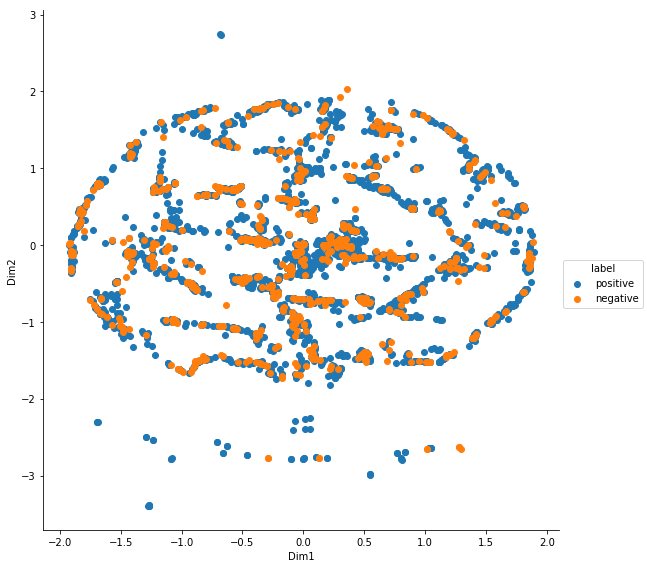

In [19]:
# Visualization

sn.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

# Different Parameters

In [11]:
model = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=1500)

In [12]:
tsne_data = model.fit_transform(final_counts) 

In [15]:
tsne_data = np.vstack((tsne_data.T, labels)).T

In [16]:
tsne_df = pd.DataFrame(data = tsne_data, columns = ('Dim1', 'Dim2', 'label'))

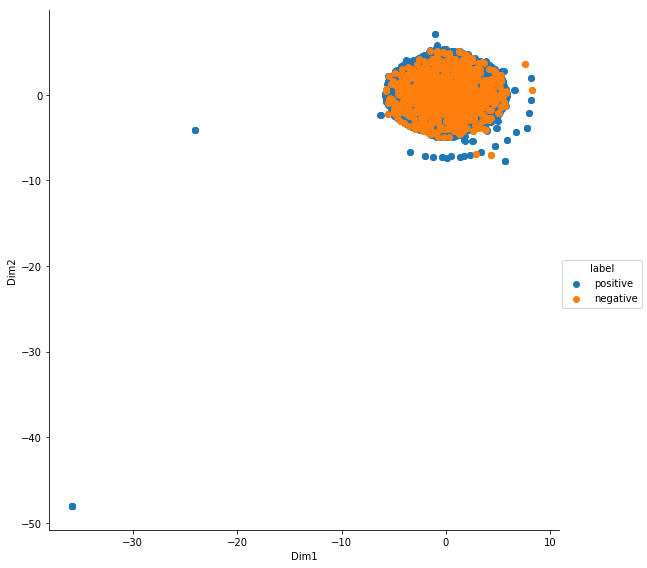

In [17]:
# Visualization

sn.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

# Observations :
-> The t-sne with default perplexity = 30 and iterations = 1000 gives better visualization.

-> The t-sne with different parameters changing perplexity to 5 and iterations = 1500 gives a dense populated data.

## TF-IDF

In [6]:
# TF-IDF

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)

In [7]:
final_tf_idf = scaling.fit_transform(final_tf_idf)

In [8]:
final_tf_idf = final_tf_idf.todense()

In [8]:
final_tf_idf = TSNE(n_jobs=4).fit_transform(final_tf_idf)

In [12]:
tsne_data = np.vstack((final_tf_idf.T, labels)).T

In [13]:
tsne_df = pd.DataFrame(data = tsne_data, columns = ('Dim1', 'Dim2', 'label'))

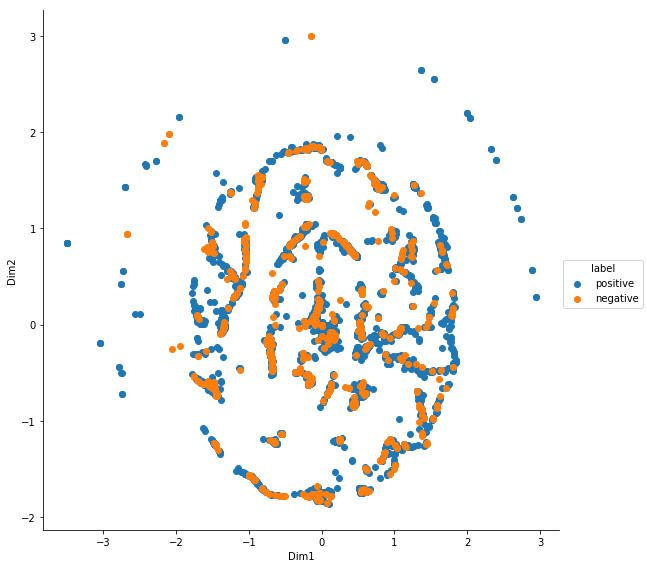

In [14]:
# Visualization

sn.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

# Different Parameters

In [9]:
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=500)

In [10]:
tsne_data = model.fit_transform(final_tf_idf) 

In [13]:
tsne_data = np.vstack((tsne_data.T, labels)).T

In [14]:
tsne_df = pd.DataFrame(data = tsne_data, columns = ('Dim1', 'Dim2', 'label'))

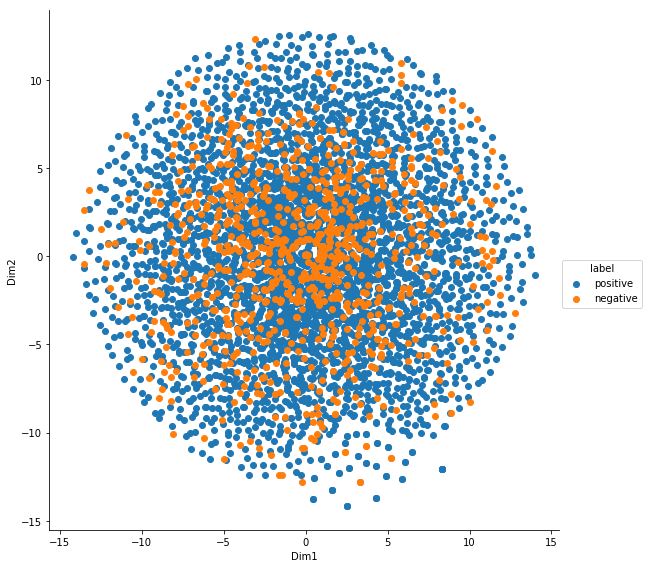

In [15]:
# Visualization

sn.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

# Observations :
-> The t-sne with default perplexity = 30 and iterations = 1000 gives more sparse visualization.

-> The t-sne with different parameters changing perplexity to 50 and iterations = 500 gives a combination of both sparse and dense populated looking data.

## Average W2V

In [16]:
# W2V

is_your_ram_gt_16g=False
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Decode

In [17]:
final['CleanedText'] = final['CleanedText'].str.decode('utf-8')

In [18]:
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [19]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [20]:
w2v_words = list(w2v_model.wv.vocab)

In [21]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 5000/5000 [00:04<00:00, 1164.73it/s]

5000
50


In [30]:
from MulticoreTSNE import MulticoreTSNE as TSNE
sent_vectors = TSNE(n_jobs=4).fit_transform(np.array(sent_vectors))

In [35]:
tsne_data = np.vstack((sent_vectors.T, labels)).T

In [36]:
tsne_df = pd.DataFrame(data = tsne_data, columns = ('Dim1', 'Dim2', 'label'))

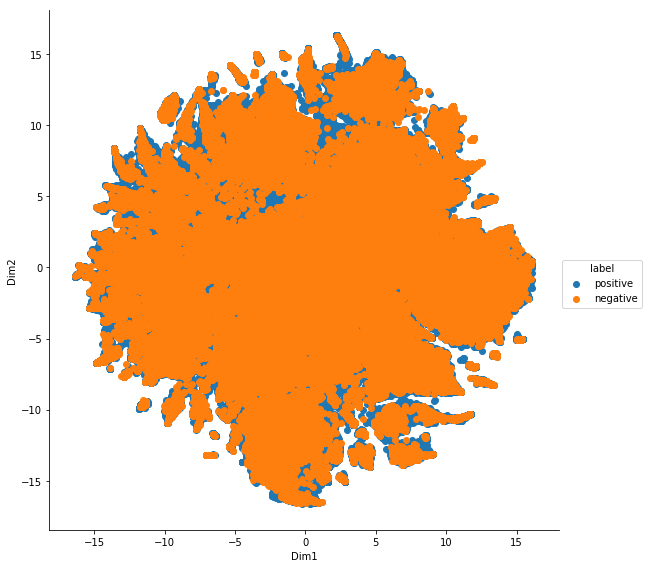

In [47]:
# Visualization

sn.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

# Different Parameters

In [23]:
model = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=1500)

In [25]:
tsne_data = model.fit_transform(np.array(sent_vectors)) 

In [26]:
tsne_data = np.vstack((tsne_data.T, labels)).T

In [27]:
tsne_df = pd.DataFrame(data = tsne_data, columns = ('Dim1', 'Dim2', 'label'))

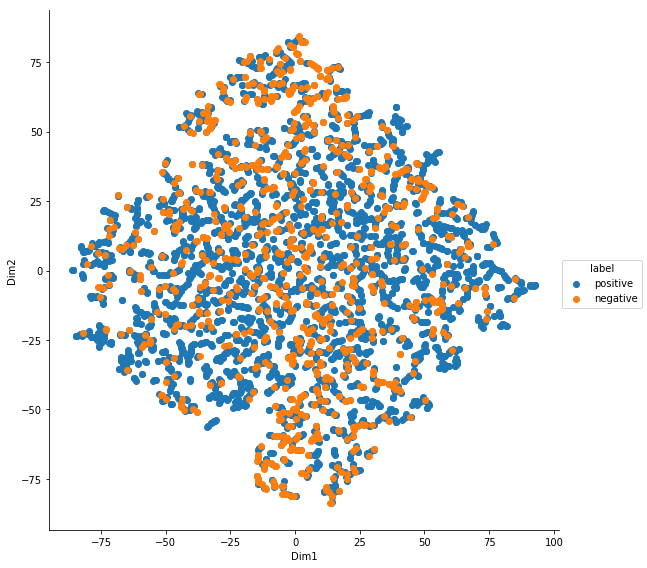

In [28]:
# Visualization

sn.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

# Observations :
-> The t-sne with default perplexity = 30 and iterations = 1000 gives more dense visualization.

-> The t-sne with different parameters changing perplexity to 5 and iterations = 1500 gives a combination of both sparse and dense populated data.

# TF-IDF W2V

In [29]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [30]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:05<00:00, 906.97it/s] 


In [31]:
from MulticoreTSNE import MulticoreTSNE as TSNE
tfidf_sent_vectors = TSNE(n_jobs=4).fit_transform(np.array(tfidf_sent_vectors))

In [40]:
tsne_data = np.vstack((tfidf_sent_vectors.T, labels)).T

In [41]:
tsne_df = pd.DataFrame(data = tsne_data, columns = ('Dim1', 'Dim2', 'label'))

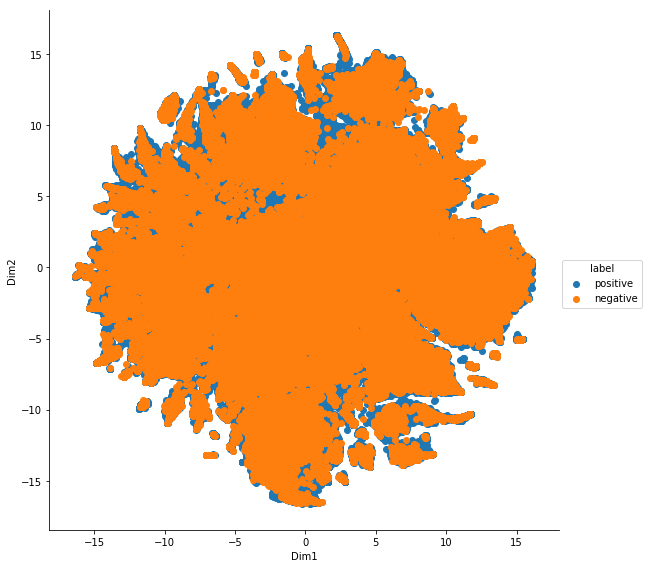

In [42]:
# Visualization

sn.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

# Different Parameters

In [31]:
model = TSNE(n_components=2, random_state=0, perplexity=15, n_iter=2000)

In [33]:
tsne_data = model.fit_transform(np.array(tfidf_sent_vectors)) 

In [34]:
tsne_data = np.vstack((tsne_data.T, labels)).T

In [35]:
tsne_df = pd.DataFrame(data = tsne_data, columns = ('Dim1', 'Dim2', 'label'))

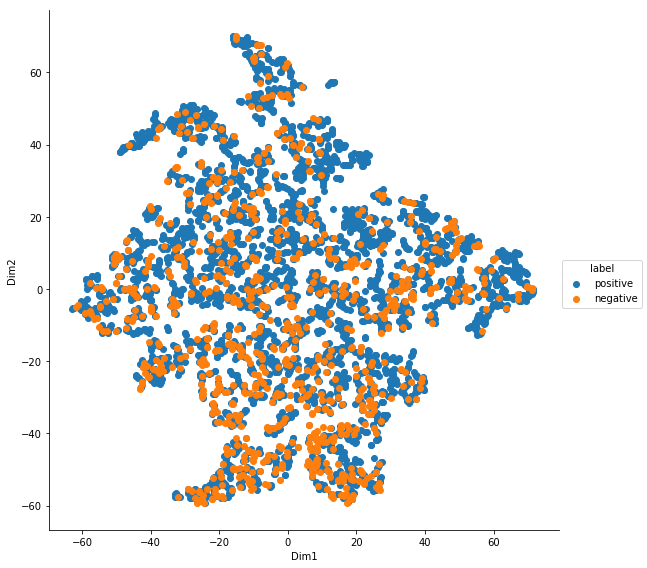

In [36]:
# Visualization

sn.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

# Observations :
-> The t-sne with default perplexity = 30 and iterations = 1000 gives more dense visualization.

-> The t-sne with different parameters changing perplexity to 15 and iterations = 2000 gives a combination of both sparse and dense populated looking data.

# Final Observations and Conclusions :
-> BOW with default parameters had nice visualization compared to different parameters.

-> Tf-IDF with default parameters had nice visualization compared to different parameters.

-> Avg w2v with different parameters had nice visualization compared to default parameters.

-> TF-IDF w2v with different parameters had nice visualization compared to default parameters.

-> By using T-sne we can able to visualize sparse and the density of the data based on different perplexity and iterations.